In [29]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import networkx as nx

In [35]:

def load_group_comparison_data(file_path, degree_dict):
    """
    Load the group comparison data from the file path
    :param file_path: the file path to the group comparison data
    :return: a dataframe with the median ranks for each group comparison
    """
    
    # if file path does not end in / add one
    if file_path[-1] != '/':
        file_path = file_path + '/'
    print(file_path)
    # ,head_label,relation_label,tail_label,rank,head_degree,tail_degree,population
    df_euro_afr = pd.read_csv(f'{file_path}ASVD/euro_afr_gene_causes_mondo_European_v_African_g2p_rankings_hist.csv')

    sub = df_euro_afr[df_euro_afr['tail_label']=='MONDO:0054743']
    df_asian = pd.read_csv(f'{file_path}ASVD/euro_eas_gene_causes_mondo_European_v_East_Asian_g2p_rankings_hist.csv')
    df_latino = pd.read_csv(f'{file_path}ASVD/euro_latino_gene_causes_mondo_European_v_Latino_g2p_rankings_hist.csv')

    # split euro and african from df_euro_afr into seporate dfs
    df_euro = df_euro_afr[df_euro_afr['population']=='European']
    df_afr = df_euro_afr[df_euro_afr['population']=='African']
    
    # remove European from asian and latino dfs
    df_eas = df_asian[df_asian['population']!='European']
    df_lat = df_latino[df_latino['population']=='Latino']
    
    # combine all dfs into one
    df_asvd = pd.concat([df_euro,df_afr,df_eas,df_lat])
    
    # add a column for the predicted entity type - the node I predicted with pykeen, the opposite is the piece of information specific to the group
    df_asvd['predicted_entity'] = 'head'
    cancer_df = pd.read_csv(f'{file_path}CancerVsRandom/monarch_transE_Cancer_v_Random_500_42_g2p_rankings_hist.csv')
    cancer_df['predicted_entity'] = 'tail'
    
    # replace Random_500_42 with Random in cancer
    cancer_df['population'] = cancer_df['population'].replace('Random_500_42','Random')
    sex_df = pd.read_csv(f'{file_path}SexDiffExp/sex_diff_genes_mondo_Female_v_Male_g2p_rankings_hist.csv')
    sex_df['predicted_entity'] = 'tail'

    # load the pediatric cancer data
    peds_df = pd.read_csv(f'{file_path}PediatricCancerVsRandom/pediatric_Pediatric_Cancer_v_Random_500_42_g2p_rankings_hist.csv')
    peds_df['predicted_entity'] = 'head'
    # remove random rows
    peds_df = peds_df[peds_df['population']!='Random_500_42']
    # remove duplicate rows in peds
    peds_df = peds_df.drop_duplicates(subset=['head_label','tail_label','population','rank'])

    # remove degree columns
    df_asvd = df_asvd.drop(columns=['head_degree','tail_degree'])
    cancer_df = cancer_df.drop(columns=['head_degree','tail_degree'])
    sex_df = sex_df.drop(columns=['head_degree','tail_degree'])
    peds_df = peds_df.drop(columns=['head_degree','tail_degree'])

    # re add the degree columns using head and tail labels and the degree dictionary
    df_asvd['head_degree'] = df_asvd['head_label'].map(degree_dict)
    df_asvd['tail_degree'] = df_asvd['tail_label'].map(degree_dict)
    cancer_df['head_degree'] = cancer_df['head_label'].map(degree_dict)
    cancer_df['tail_degree'] = cancer_df['tail_label'].map(degree_dict)
    sex_df['head_degree'] = sex_df['head_label'].map(degree_dict)
    sex_df['tail_degree'] = sex_df['tail_label'].map(degree_dict)
    peds_df['head_degree'] = peds_df['head_label'].map(degree_dict)
    peds_df['tail_degree'] = peds_df['tail_label'].map(degree_dict)

    # add a for the predicted entity degree and the given entity degree
    df_asvd['predicted_entity_degree'] = df_asvd['head_degree']
    df_asvd['given_entity_degree'] = df_asvd['tail_degree']
    cancer_df['predicted_entity_degree'] = cancer_df['tail_degree']
    cancer_df['given_entity_degree'] = cancer_df['head_degree']
    sex_df['predicted_entity_degree'] = sex_df['tail_degree']
    sex_df['given_entity_degree'] = sex_df['head_degree']
    peds_df['predicted_entity_degree'] = peds_df['tail_degree']
    peds_df['given_entity_degree'] = peds_df['head_degree']

    non_medianed_df = pd.concat([df_asvd,cancer_df,sex_df,peds_df])

    # for sex_df group by head_label and population and get the median rank
    sex_df = sex_df[['population','head_label','rank','given_entity_degree']].groupby(['population','head_label']).median().reset_index().sort_values(by='rank',ascending=True)

    # same thing for cancer_df
    cancer_df = cancer_df[['population','head_label','rank','given_entity_degree','predicted_entity_degree']].groupby(['population','head_label']).median().reset_index().sort_values(by='rank',ascending=True)

    # same thing for peds_df
    peds_df = peds_df[['population','head_label','rank','given_entity_degree','predicted_entity_degree']].groupby(['population','head_label']).median().reset_index().sort_values(by='rank',ascending=True)

    # same thing for df_asvd but use tail_label instead of head_label
    df_asvd = df_asvd[['population','tail_label','rank','given_entity_degree','predicted_entity_degree']].groupby(['population','tail_label']).median().reset_index().sort_values(by='rank',ascending=True)

    # combine all dfs into one
    df = pd.concat([df_asvd,cancer_df,sex_df,peds_df])
    return df, non_medianed_df


# Degree vs rank

In [31]:
def degree_vs_median_rank(df,output):
    # for each population, plot the rank vs degree

    # list populations in order of the number of rows in the df
    # sort populations by number of rows
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    populations = ['Female','Male','European','African','East_Asian','Latino','Cancer','Random','Pediatric_Cancer']

    fig, axes = plt.subplots(2,5,figsize=(12,5))
    for i,pop in enumerate(populations):
        x = i%2
        y = i//2
        df_pop = df[df['population']==pop]
        print(pop,df_pop.shape)
        axes[x,y].scatter(df_pop['given_entity_degree'],df_pop['rank'],label=pop,s=3,alpha=0.5,color=colors[i])
        # remove top and right border
        axes[x,y].spines['top'].set_visible(False)
        axes[x,y].spines['right'].set_visible(False)
        # set x and y labels
        axes[x,y].set_xlabel('Degree')
        axes[x,y].set_ylabel('Median rank')
        axes[x,y].set_title(pop)
    
    # remove the last subplot
    axes[1,4].axis('off')
    
    # save figure
    plt.tight_layout()
    plt.savefig(output,dpi=300,bbox_inches='tight')
    plt.show()


In [32]:
def median_rank_hist(df,output):
    # do a histogram of the rank of each population
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    populations = ['Female','Male','European','African','East_Asian','Latino','Cancer','Random','Pediatric_Cancer']


    fig, axes = plt.subplots(2,5,figsize=(12,5))
    for i,pop in enumerate(populations):
        x = i%2
        y = i//2
        df_pop = df[df['population']==pop]
        axes[x,y].hist(df_pop['rank'],label=pop,color=colors[i])
        
        # remove top and right border
        axes[x,y].spines['top'].set_visible(False)
        axes[x,y].spines['right'].set_visible(False)
        # set x and y labels
        axes[x,y].set_xlabel('Rank')
        axes[x,y].set_ylabel('Frequency')
        # set the median value as a vertical line
        axes[x,y].axvline(df_pop['rank'].median(),color='red',label='median')
        med = df_pop['rank'].median()
        axes[x,y].set_title(pop + f'\nmedian: {med:.2f}')
    # remove the last subplot
    axes[1,4].axis('off')
    # save figure
    plt.tight_layout()
    plt.savefig(output,dpi=300,bbox_inches='tight')
    plt.show()

In [33]:
# violin plots of median rank
def violin_plot(non_medianed_df,output):
    populations = ['Female','Male','European','African','East_Asian','Latino','Cancer','Random','Pediatric_Cancer']

    fig, ax = plt.subplots(figsize=(12,5))
    for i,pop in enumerate(populations):
        x = i%2
        y = i//2
        df_pop = non_medianed_df[non_medianed_df['population']==pop]
        # violin plot of the rank   
        ax.violinplot(df_pop['rank'],positions=[i],showmedians=True)
        
        # remove top and right border
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # set x and y labels
        ax.set_ylabel('Rank of Edges in Test Set')
        # set the median value as a vertical line
        print(pop,df_pop['rank'].median())

    # label the x ticks
    ax.set_xticks(range(len(populations)))
    ax.set_xticklabels(populations)
        
    # save figure
    plt.tight_layout()
    plt.savefig(output,dpi=300,bbox_inches='tight')
    plt.show()   

# TransE Monarch KG

../GroupComparisonResults/original_monarch/TransE/
Female (6850, 6)
Male (6508, 6)
European (94, 6)
African (40, 6)
East_Asian (37, 6)
Latino (60, 6)
Cancer (335, 6)
Random (1163, 6)
Pediatric_Cancer (2124, 6)


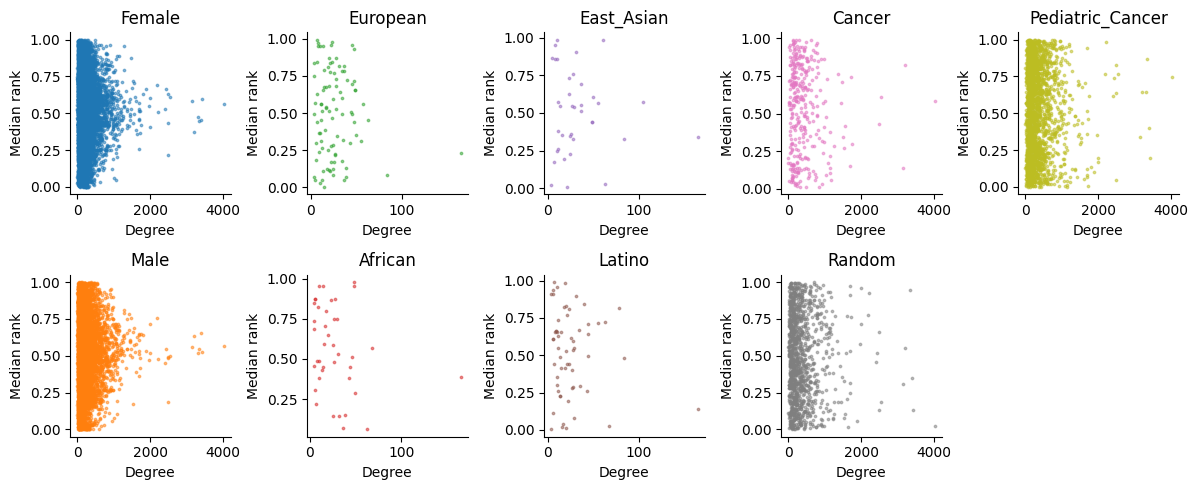

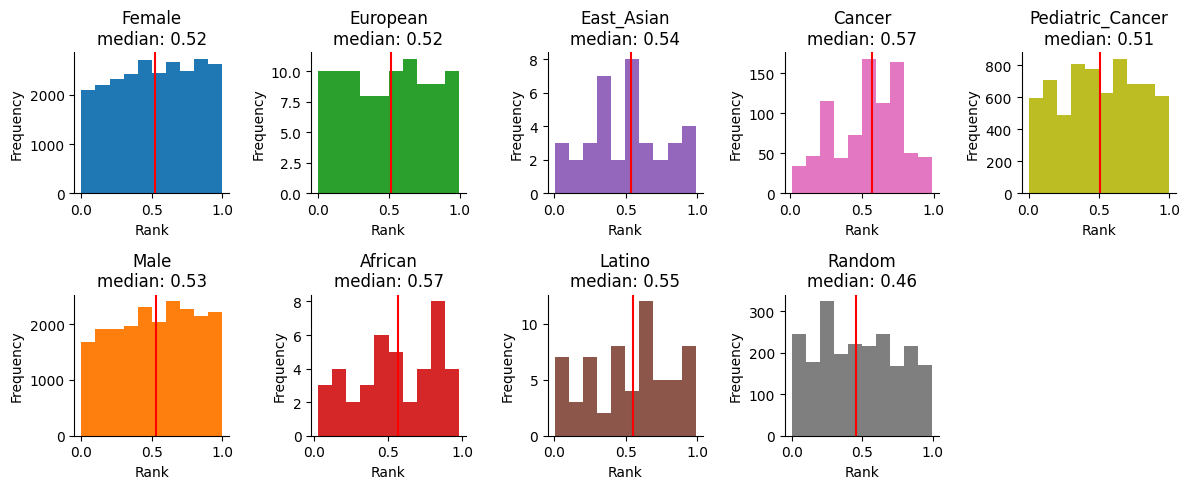

Female 0.5219095287562565
Male 0.5323448862026632
European 0.5167854950658671
African 0.5681571367864394
East_Asian 0.5390717219887624
Latino 0.5514424665942679
Cancer 0.5670034941920862
Random 0.4585891018981962
Pediatric_Cancer 0.5071300406081783


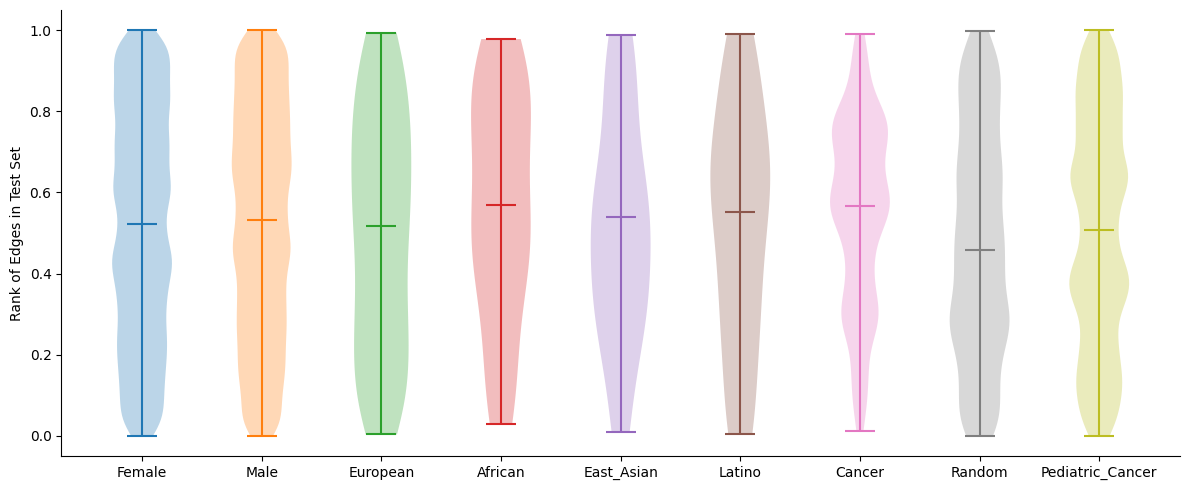

In [36]:
# make a degree diction for the graph
# read the triples
file_path = '../ELs_for_Rotate/Monarch_KG/train.txt'
df = pd.read_csv(file_path, sep='\t', header=None)
df.columns = ['head', 'relation', 'tail']

df.head()

# make a graph
G = nx.from_pandas_edgelist(df, 'head', 'tail', create_using=nx.DiGraph())
# make a degree dictionary
degree_dict = dict(G.degree(G.nodes()))

df, non_medianed_df = load_group_comparison_data('../GroupComparisonResults/original_monarch/TransE',degree_dict)
non_medianed_df_transE_og = non_medianed_df
degree_vs_median_rank(df,'../Figures/group_comparison_degree_v_rank_scatter.transe.monarch.png')
median_rank_hist(non_medianed_df,'../Figures/group_comparison_degree_v_rank_hists.transe.monarch.png')
violin_plot(non_medianed_df,'../Figures/group_comparison_rank_violin.transe.monarch.png')

In [22]:
df.head() 
df.shape

(15087, 6)

# ComplEx Monarch KG

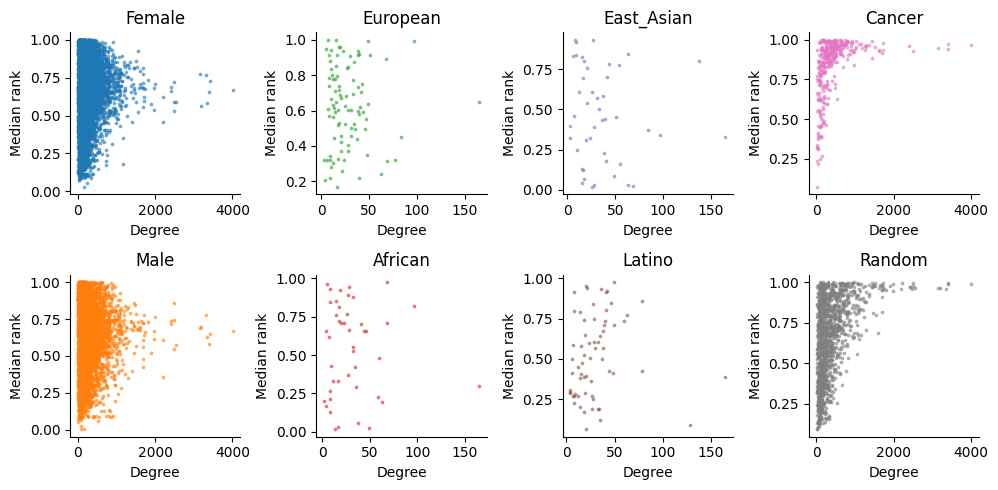

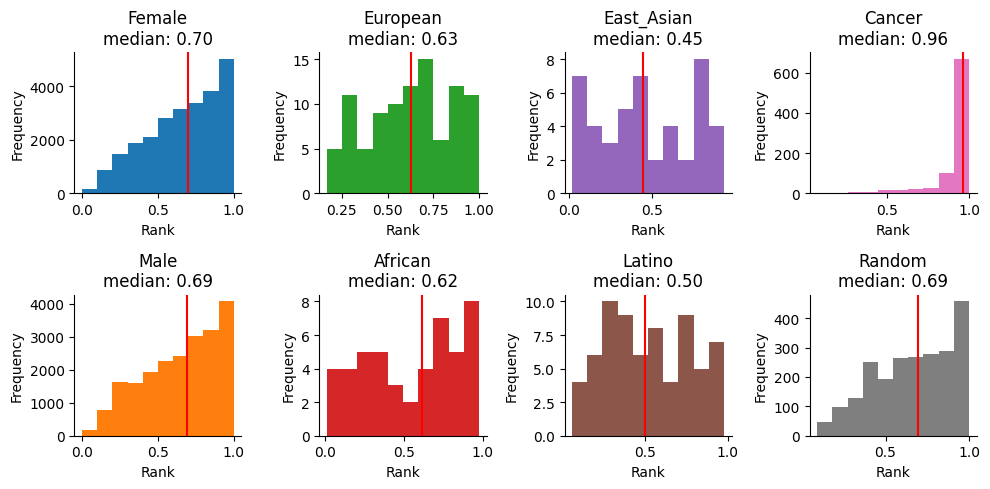

Female 0.697241639901757
Male 0.6899678821084451
European 0.6272375194823596
African 0.6183346715156095
East_Asian 0.44762197137864257
Latino 0.5025031880224815
Cancer 0.9640090685811448
Random 0.6946438692612885


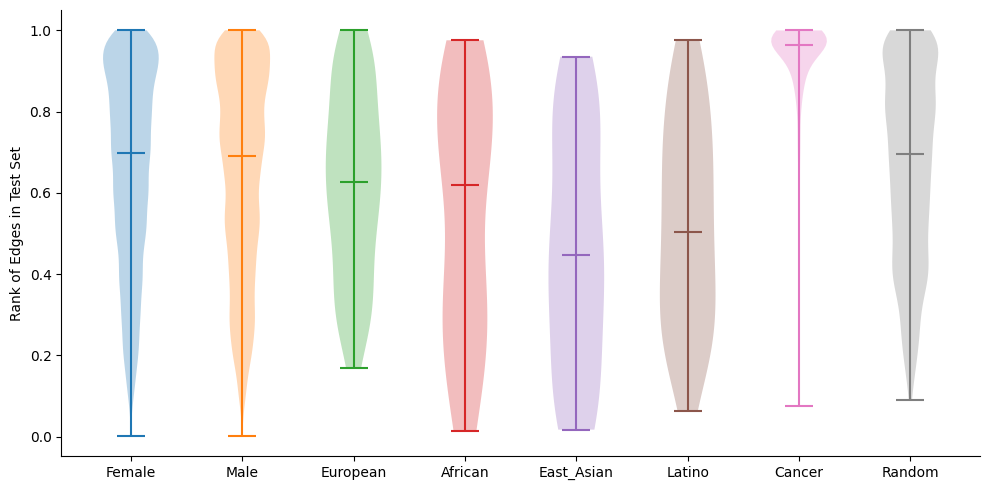

In [48]:
df, non_medianed_df = load_group_comparison_data('../GroupComparisonResults/original_monarch/ComplEx',degree_dict)
degree_vs_median_rank(df,'../Figures/group_comparison_degree_v_rank_scatter.complex.monarch.png')
median_rank_hist(non_medianed_df,'../Figures/group_comparison_degree_v_rank_hists.complex.monarch.png')
violin_plot(non_medianed_df,'../Figures/group_comparison_rank_violin.complex.monarch.png')

# RotatE Monarch KG

In [42]:
df, non_medianed_df = load_group_comparison_data('../GroupComparisonResults/original_monarch/RotatE',degree_dict)
degree_vs_median_rank(df,'../Figures/group_comparison_degree_v_rank_scatter.rotate.monarch.png')
# median_rank_hist(df,'../Figures/group_comparison_degree_v_rank_hists.rotate.monarch.png')
median_rank_hist(non_medianed_df,'../Figures/group_comparison_degree_v_rank_hists.rotate.monarch.png')
violin_plot(non_medianed_df,'../Figures/group_comparison_rank_violin.rotate.monarch.png')

../GroupComparisonResults/original_monarch/RotatE/


FileNotFoundError: [Errno 2] No such file or directory: '../GroupComparisonResults/original_monarch/RotatE/PediatricCancerVsRandom/pediatric_Pediatric_Cancer_v_Random_500_42_g2p_rankings_hist.csv'



# <p style="text-align: center;"> **Monarch - HuRI** </p>




# TransE Monarch HuRI
The HGNC edges and nodes not present in HuRI have been removed, anything in HuRI but not in HGNC have been added. This is an attempt at addressing study bias

../GroupComparisonResults/HuRI/TransE/
Female (672, 6)
Male (730, 6)
European (33, 6)
African (18, 6)
East_Asian (13, 6)
Latino (23, 6)
Cancer (3, 6)
Random (104, 6)
Pediatric_Cancer (169, 6)


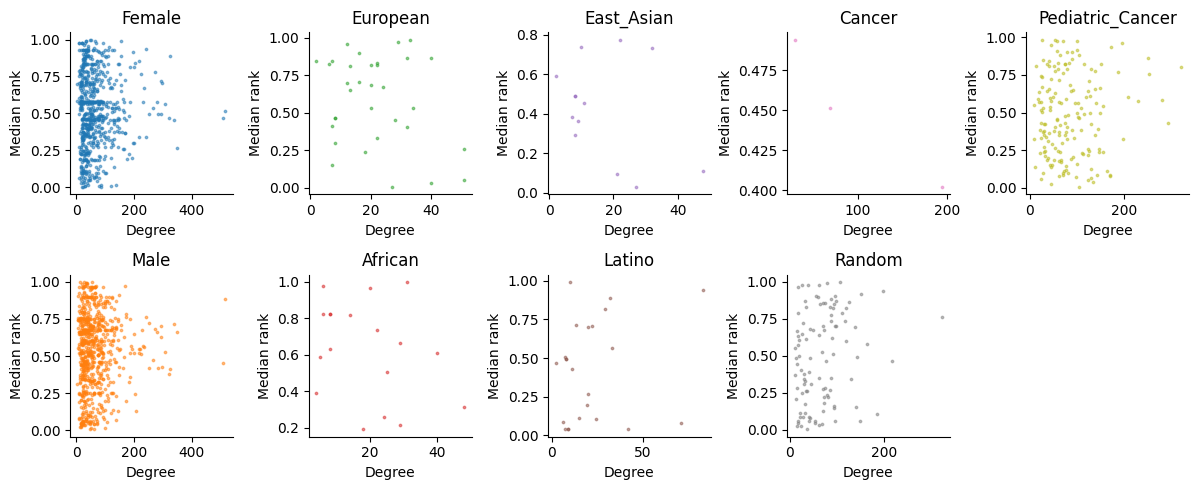

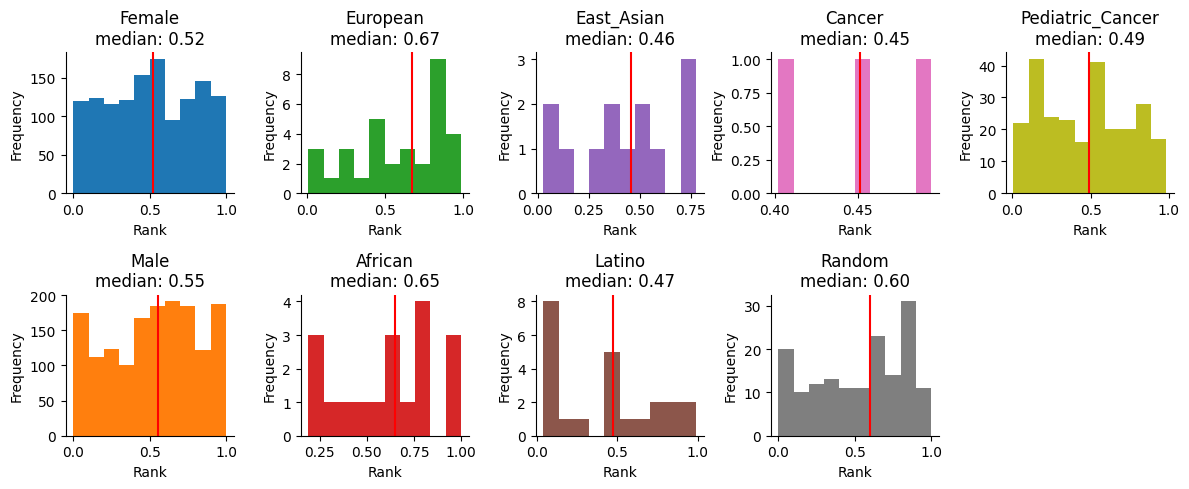

Female 0.5223409422049539
Male 0.5548810101991257
European 0.6720893529197524
African 0.6496904212698797
East_Asian 0.4564768726478087
Latino 0.4703168629355347
Cancer 0.4514327343370568
Random 0.6026590577950461
Pediatric_Cancer 0.4898008742107819


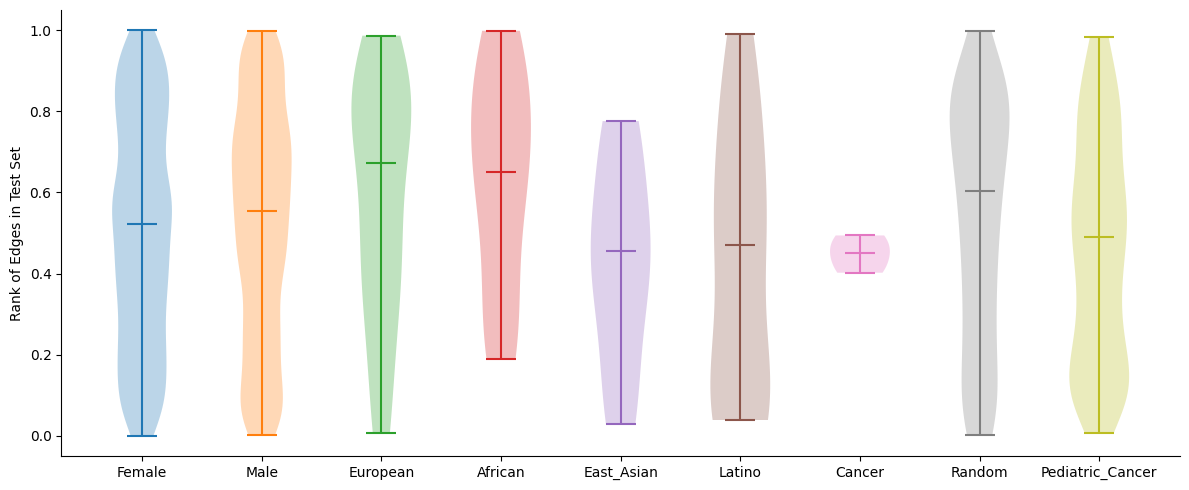

In [43]:
# make a degree diction for the graph
# read the triples
file_path = '../ELs_for_Rotate/Monarch_HuRI/monarch_HuRI.train.tsv'
df = pd.read_csv(file_path, sep='\t', header=None)
df.columns = ['head', 'relation', 'tail']
df.head()
# make a graph
G = nx.from_pandas_edgelist(df, 'head', 'tail', create_using=nx.DiGraph())
# make a degree dictionary
degree_dict = dict(G.degree(G.nodes()))


df, non_medianed_df = load_group_comparison_data('../GroupComparisonResults/HuRI/TransE',degree_dict)
degree_vs_median_rank(df,'../Figures/group_comparison_degree_v_rank_scatter.transe.monarch_huri.png')
median_rank_hist(non_medianed_df,'../Figures/group_comparison_degree_v_rank_hists.transe.monarch_huri.png')
violin_plot(non_medianed_df,'../Figures/group_comparison_rank_violin.transe.monarch_huri.png')

In [17]:
# print(non_medianed_df)
# len(non_medianed_df['head_label'].unique())
print('Population','Num nodes HuRI','Num nodes Monarch','HuRI/Monarch')
for pop in non_medianed_df['population'].unique():
    sub_huri = non_medianed_df[non_medianed_df['population']==pop]
    sub_og = non_medianed_df_transE_og[non_medianed_df_transE_og['population']==pop]
    print(pop, len(sub_huri['head_label'].unique()), len(sub_og['head_label'].unique()), len(sub_huri['head_label'].unique()) / len(sub_og['head_label'].unique()))

"""
32|0.271754771471024|loss.adversarial_temperature|0.890625
32|0.271754771471024|loss.margin|24.0
32|0.271754771471024|model.embedding_dim|368.0
32|0.271754771471024|negative_sampler.num_negs_per_pos|71.0
32|0.271754771471024|optimizer.lr|0.00273841963426436
32|0.271754771471024|training.batch_size|7.0
32|0.271754771471024|training.num_epochs|100.0

python Scripts/create_optimized_model_from_config.py --config rotate_huri_kg_2_mid_way_best.json --out PyKeenOut/rotate_huri_kg_2_mid_way_best

"""

Population Num nodes HuRI Num nodes Monarch HuRI/Monarch
European 33 90 0.36666666666666664
African 17 46 0.3695652173913043
East_Asian 13 45 0.28888888888888886
Latino 20 66 0.30303030303030304
Cancer 5 342 0.014619883040935672
Random 133 1239 0.10734463276836158
Female 729 6838 0.1066101199181047
Male 708 6511 0.10873905698049455


'\nTransE Monarch:\nEuropean (96, 11)\nAfrican (47, 11)\nEast_Asian (46, 11)\nLatino (68, 11)\nCancer (871, 11)\nRandom (2274, 11)\nFemale (24637, 11)\nMale (21043, 11)\n'

# RotatE Monarch HuRI


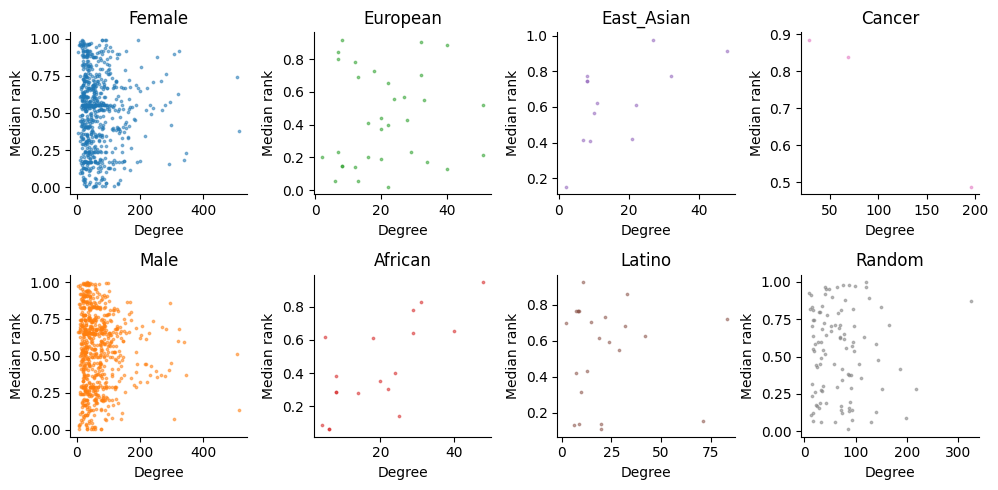

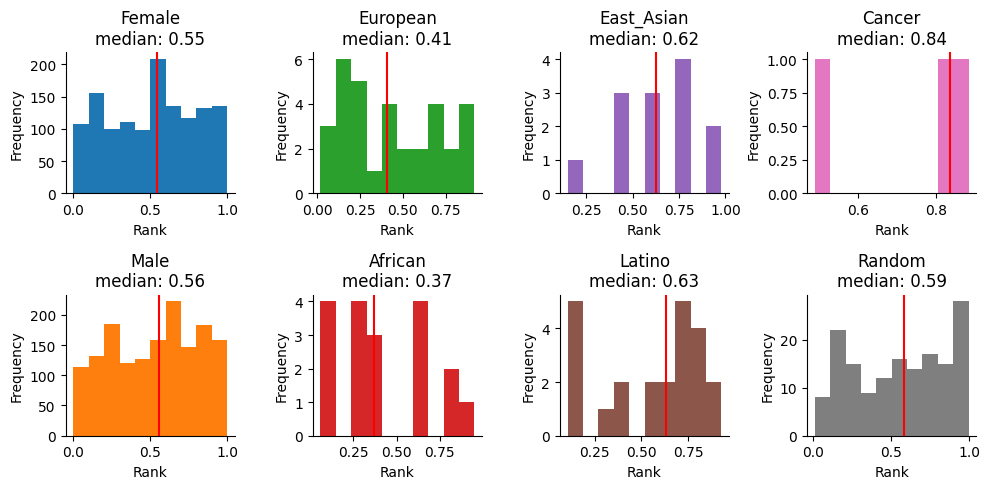

Female 0.5478387566779991
Male 0.5554273919378339
European 0.4062158552871191
African 0.3690664076726964
East_Asian 0.6240135971834406
Latino 0.6294767512443851
Cancer 0.837542496357455
Random 0.5857212238950947


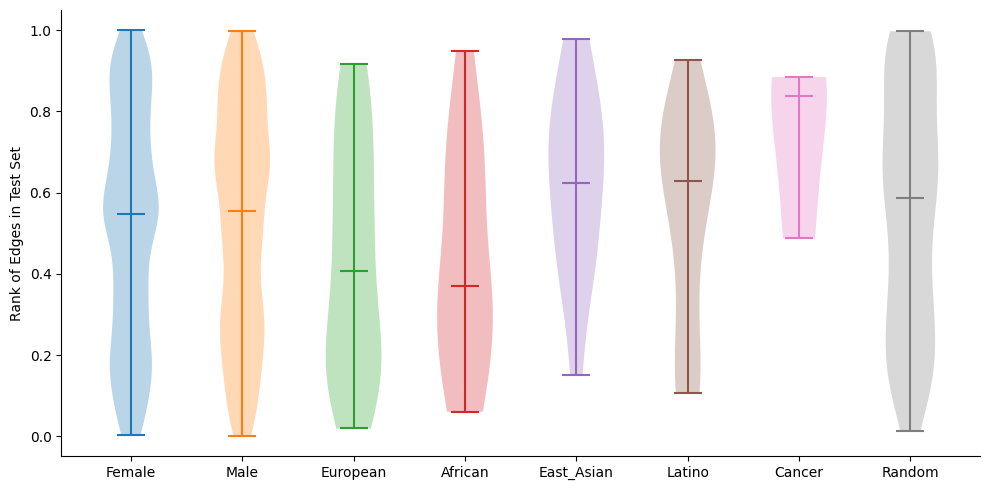

In [9]:
df, non_medianed_df = load_group_comparison_data('../GroupComparisonResults/HuRI/RotatE',degree_dict)
degree_vs_median_rank(df,'../Figures/group_comparison_degree_v_rank_scatter.rotate.monarch_huri.png')
median_rank_hist(non_medianed_df,'../Figures/group_comparison_degree_v_rank_hists.rotate.monarch_huri.png')
violin_plot(non_medianed_df,'../Figures/group_comparison_rank_violin.rotate.monarch_huri.png')

# ComplEx Monarch HuRI

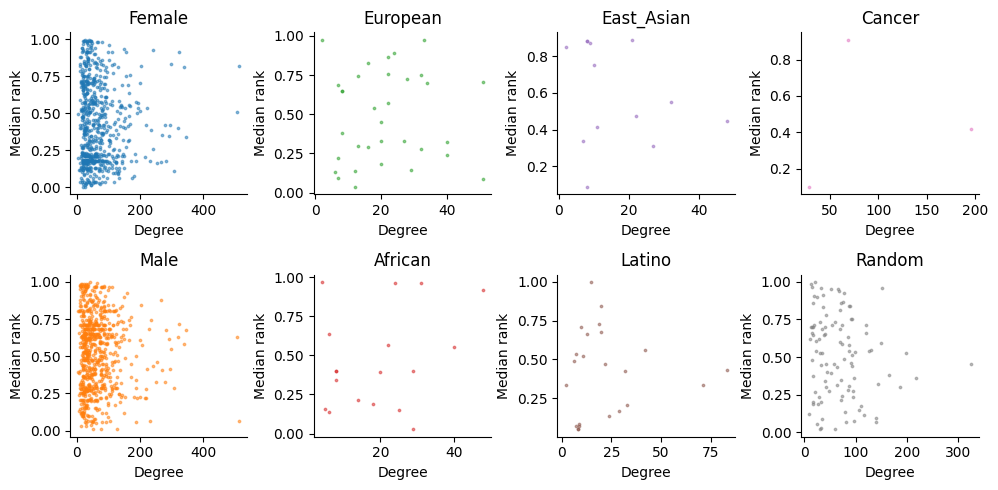

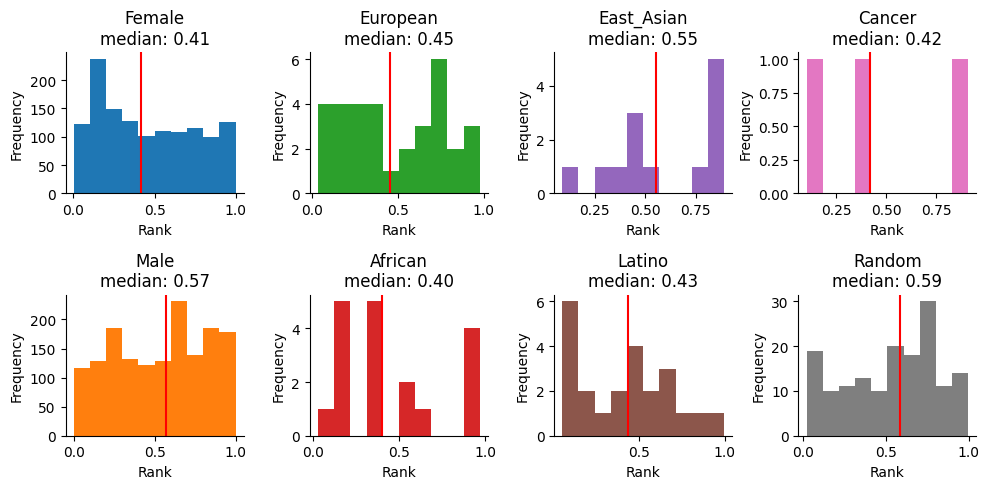

Female 0.4135502671199611
Male 0.5718795531811559
European 0.4540488041762778
African 0.4002063858200801
East_Asian 0.5515357533082433
Latino 0.4334102221682651
Cancer 0.4163428848955803
Random 0.5851748421563866


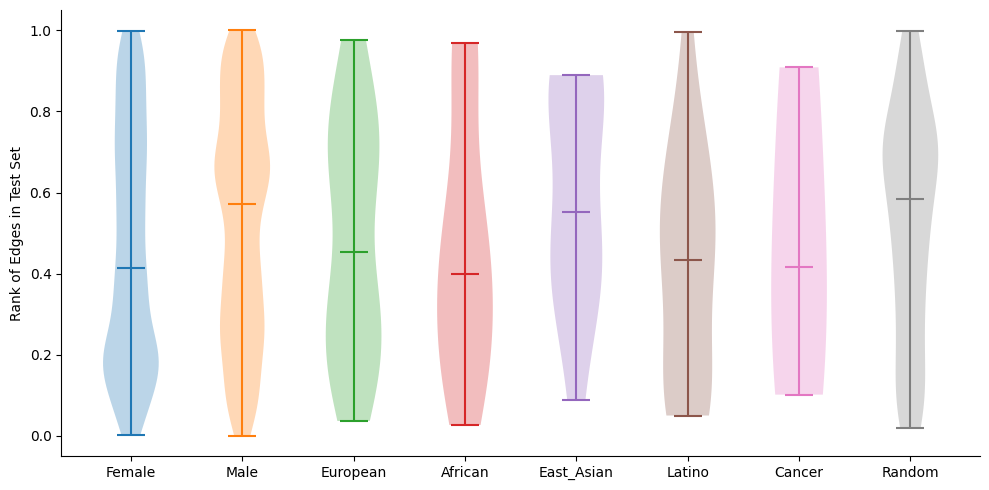

In [14]:
df, non_medianed_df = load_group_comparison_data('../GroupComparisonResults/HuRI/ComplEx',degree_dict)
degree_vs_median_rank(df,'../Figures/group_comparison_degree_v_rank_scatter.complex.monarch_huri.png')
median_rank_hist(non_medianed_df,'../Figures/group_comparison_degree_v_rank_hists.complex.monarch_huri.png')
violin_plot(non_medianed_df,'../Figures/group_comparison_rank_violin.complex.monarch_huri.png')

# Monarch HuRI Filtered

# TransE Monarch HuRI Filtered

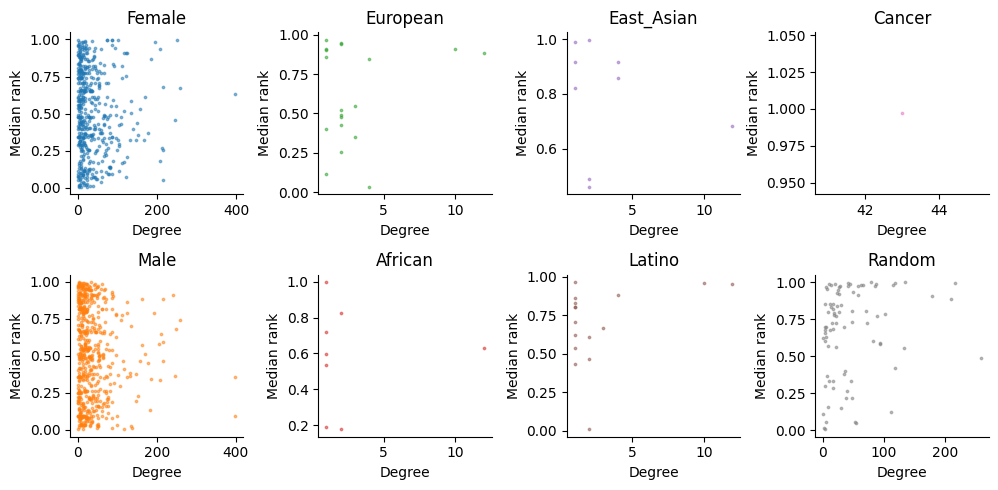

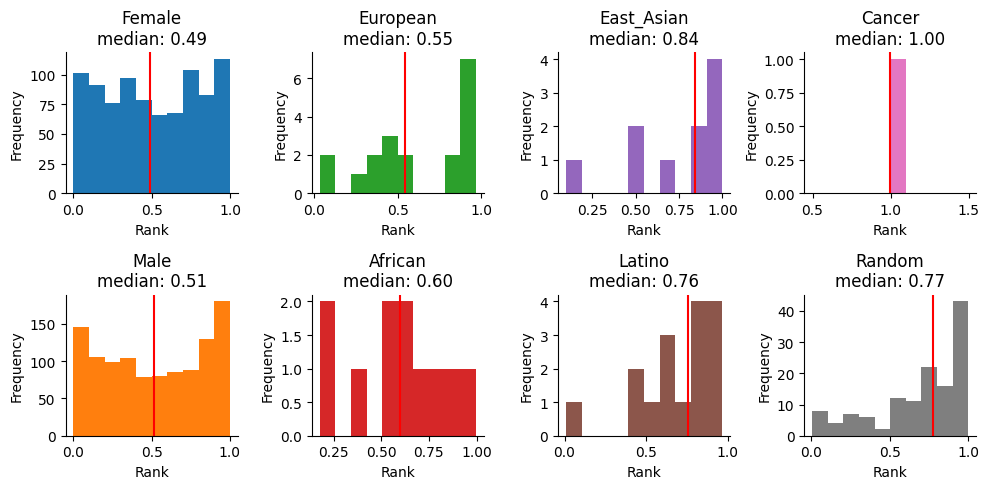

Female 0.48934280639431615
Male 0.5134483633595535
European 0.5457313205632374
African 0.5967271343397184
East_Asian 0.8402258023595077
Latino 0.7550424965114804
Cancer 0.9970819588936818
Random 0.772012179649835


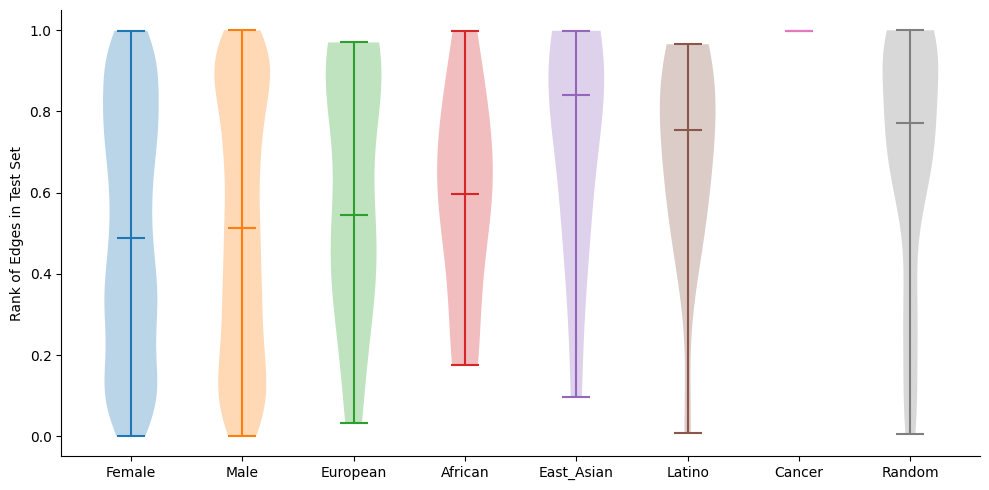

In [11]:
# make a degree diction for the graph
# read the triples
file_path = '../ELs_for_Rotate/Monarch_HuRI_Filtered/train.txt'
df = pd.read_csv(file_path, sep='\t', header=None)
df.columns = ['head', 'relation', 'tail']
df.head()
# make a graph
G = nx.from_pandas_edgelist(df, 'head', 'tail', create_using=nx.DiGraph())
# make a degree dictionary
degree_dict = dict(G.degree(G.nodes()))


df, non_medianed_df = load_group_comparison_data('../GroupComparisonResults/HuRI_filtered/TransE',degree_dict)
degree_vs_median_rank(df,'../Figures/group_comparison_degree_v_rank_scatter.transe.monarch_huri_filtered.png')
median_rank_hist(non_medianed_df,'../Figures/group_comparison_degree_v_rank_hists.transe.monarch_huri_filtered.png')
violin_plot(non_medianed_df,'../Figures/group_comparison_rank_violin.transe.monarch_huri_filtered.png')

# Monarch Filtered

# TransE Monarch Filtered

In [28]:
# make a degree diction for the graph
# read the triples
file_path = '../ELs_for_Rotate/Monarch_KG_Filtered/train.txt'
df = pd.read_csv(file_path, sep='\t', header=None)
df.columns = ['head', 'relation', 'tail']
df.head()
# make a graph
G = nx.from_pandas_edgelist(df, 'head', 'tail', create_using=nx.DiGraph())
# make a degree dictionary
degree_dict = dict(G.degree(G.nodes()))


df, non_medianed_df = load_group_comparison_data('../GroupComparisonResults/monarch_filtered/TransE',degree_dict)
degree_vs_median_rank(df,'../Figures/group_comparison_degree_v_rank_scatter.transe.monarch_filtered.png')
median_rank_hist(non_medianed_df,'../Figures/group_comparison_degree_v_rank_hists.transe.monarch_filtered.png')
violin_plot(non_medianed_df,'../Figures/group_comparison_rank_violin.transe.monarch_filtered.png')

../GroupComparisonResults/monarch_filtered/TransE/


ValueError: too many values to unpack (expected 2)

In [18]:
sub = df[df['population'] == 'Cancer']
sub.head()
# sort by rank
sub = sub.sort_values(by='rank', ascending=False)
print(sub.shape)
print(len(sub['head_label'].unique()))
print(len(sub['tail_label'].unique()))
sub.head()


(335, 6)
335
1


,population,tail_label,rank,given_entity_degree,predicted_entity_degree,head_label
53,Cancer,NaN,0.991076,297.0,599.5,HGNC:12831
120,Cancer,NaN,0.989565,201.0,3303.0,HGNC:19274
77,Cancer,NaN,0.989092,621.0,459.0,HGNC:1681
258,Cancer,NaN,0.987440,138.0,459.0,HGNC:6305
39,Cancer,NaN,0.982482,129.0,614.0,HGNC:12397


# RotatE Monarch Filtered

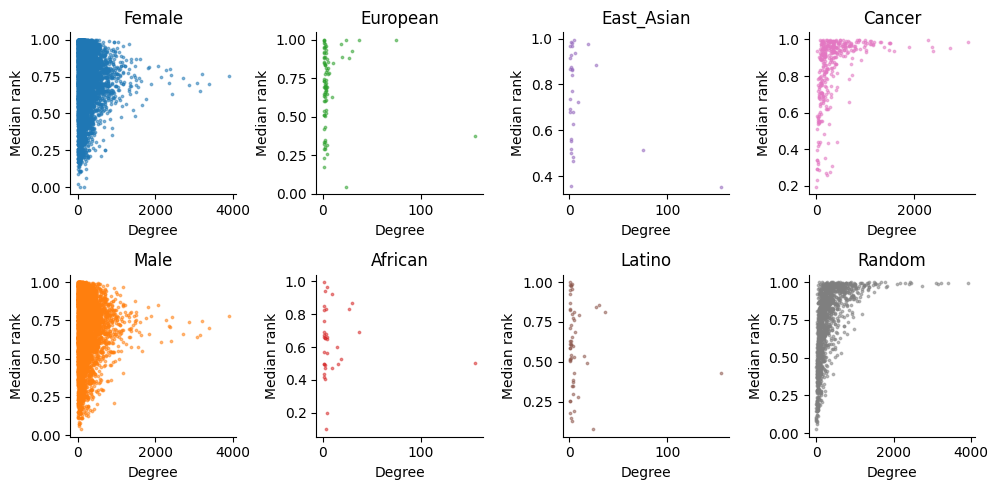

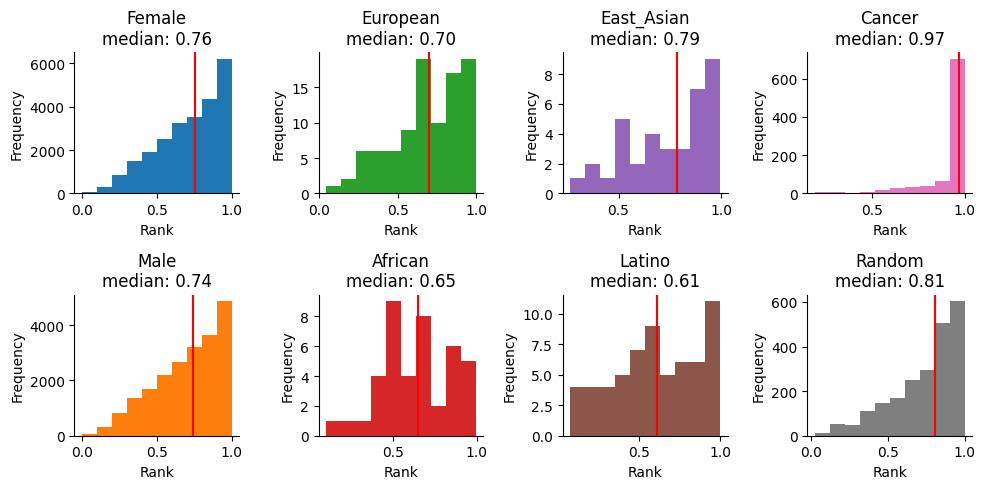

Female 0.7556385362210605
Male 0.7436893203883496
European 0.7012844767499751
African 0.6506521955590959
East_Asian 0.7865677586378572
Latino 0.6095788111122175
Cancer 0.9672392332586508
Random 0.8096091610654718


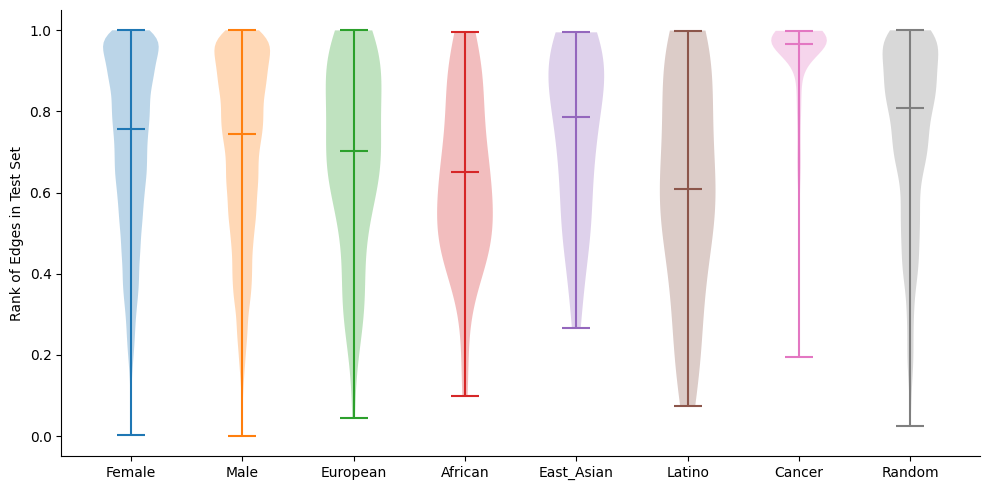

In [16]:
df, non_medianed_df = load_group_comparison_data('../GroupComparisonResults/monarch_filtered/RotatE',degree_dict)
degree_vs_median_rank(df,'../Figures/group_comparison_degree_v_rank_scatter.rotate.monarch_filtered.png')
median_rank_hist(non_medianed_df,'../Figures/group_comparison_degree_v_rank_hists.rotate.monarch_filtered.png')
violin_plot(non_medianed_df,'../Figures/group_comparison_rank_violin.rotate.monarch_filtered.png')

# ComplEx Monarch HuRI

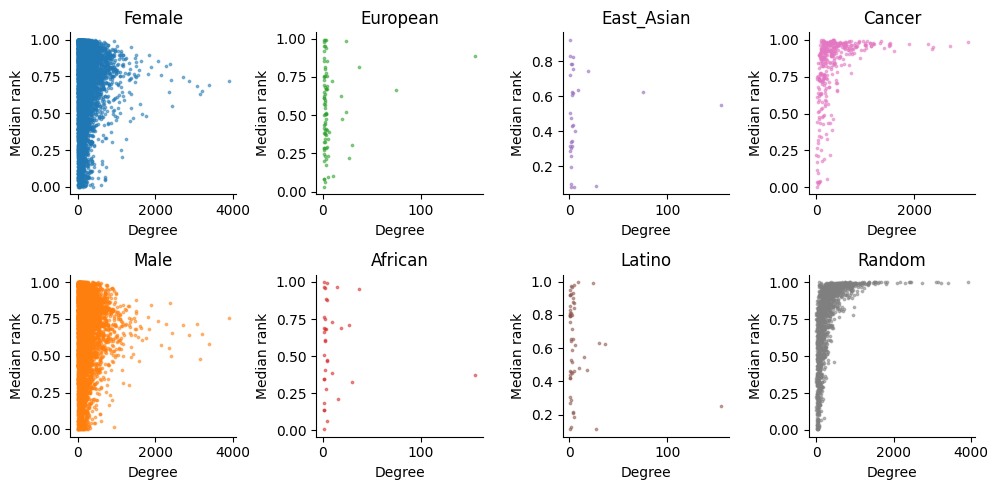

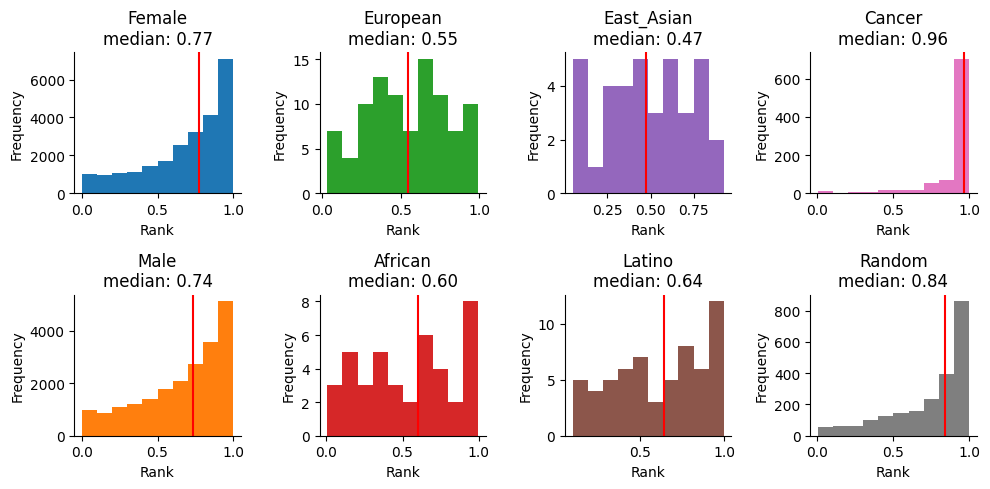

Female 0.774807069952701
Male 0.7360219068956934
European 0.547943841481629
African 0.6002190580503833
East_Asian 0.4734641043512894
Latino 0.63945036343722
Cancer 0.9635051033109284
Random 0.8407269106298233


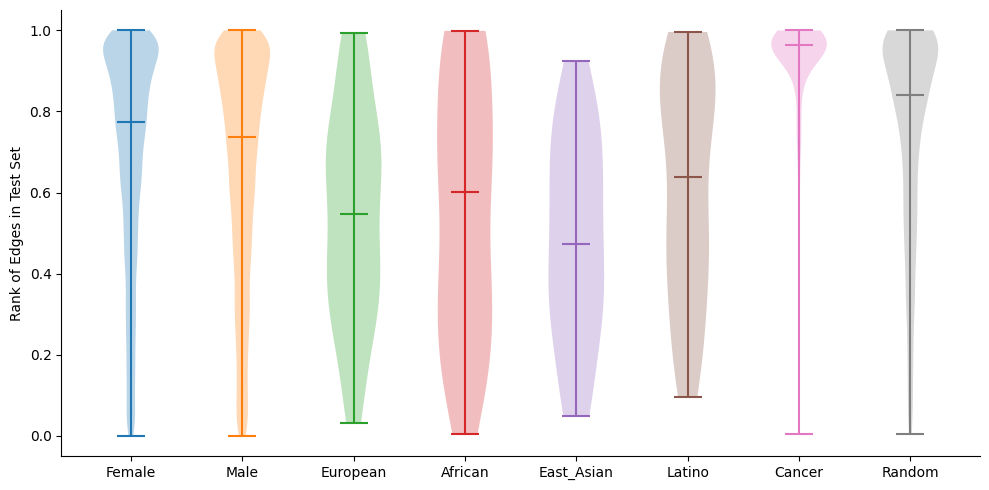

In [17]:
df, non_medianed_df = load_group_comparison_data('../GroupComparisonResults/monarch_filtered/ComplEx',degree_dict)
degree_vs_median_rank(df,'../Figures/group_comparison_degree_v_rank_scatter.complex.monarch_filtered.png')
median_rank_hist(non_medianed_df,'../Figures/group_comparison_degree_v_rank_hists.complex.monarch_filtered.png')
violin_plot(non_medianed_df,'../Figures/group_comparison_rank_violin.complex.monarch_filtered.png')